# Lecture 1: Introduction to Machine Learning

In this lecture, we will introduce the basics of machine learning.

Let's start by exploring what neural network training looks like under the hood.

## Part 1: Backpropagation

Backpropagation algorithm is the cornerstone of training neural networks. (used in all neural nets) It is a method to calculate the gradient of the loss function with respect to the weights of the network.

**The main problem is... how do computers compute the gradient?**

Humans get the gradient by calculating the derivative, then plug in the values.

Computers can't do that:
1. Derivatives are hard to calculate
2. Neural networks are huge

Let's build our own backpropagation algorithm from scratch step by step.



In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt

### Manual Gradient Calculation

In [2]:
# Define a random function
# f(x) = 3x^2 - 4x + 5
# ------------------
# Write your implementation here.
def f(x):
    return 3 * x ** 2 - 4 * x + 5
# ------------------

In [3]:
f(2)

9

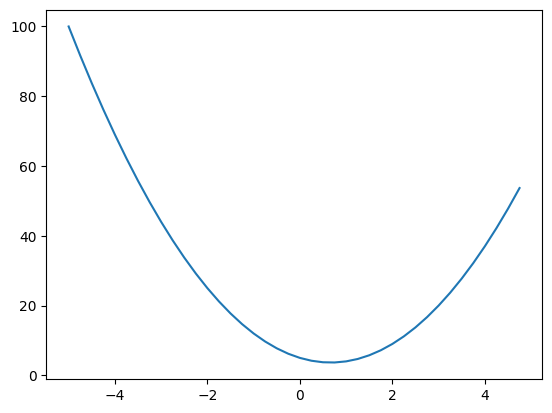

In [4]:
# Plot the function
xs = np.arange(-5, 5, 0.25)  # np.arange(start, stop, step)
ys = [f(x) for x in xs]
plt.plot(xs, ys)

In [5]:
# What is the gradient of f(x) at x=2?
# Human approach
# f'(x) = 6x - 4 -> f'(2) = 6*2 - 4 = 8

# Computer approach
# gradient = (f(x + h) - f(x)) / h
# h = small number
def gradient(f, x, h=0.0001):
    return (f(x + h) - f(x)) / h

In [6]:
gradient(f, 2)

8.000300000023941

In [7]:
def f(x, y, z):
    return (x + y) * z

In [8]:
f(-2, 5, -4)

-12

![(x + y) * z](assets/(x+y)z.png)

**Goal**:
1. dg/dx
2. dg/dy
3. dg/dz

In [9]:
# Get the derivative of f(x, y, z) with respect to x, y, z
h = 0.0001
# Derivative of f with respect to x=2
df_dx = (f(-2 + h, 5, -4) - f(-2, 5, -4)) / h
print(f"df/dx: {df_dx}")
# Derivative of f with respect to y=-3
df_dy = (f(2, 5 + h, -4) - f(2, 5, -4)) / h
print(f"df/dy: {df_dy}")
# Derivative of f with respect to z=10
df_dz = (f(2, 5, -4 + h) - f(2, 5, -4)) / h
print(f"df/dz: {df_dz}")

df/dx: -3.9999999999906777
df/dy: -3.9999999999906777
df/dz: 7.000000000019213


![chain rule](assets/chain_rule.png)

**Chain Rule**:

q = x + y

f = q * z

1. df/dx = df/dq * dq/dx
2. df/dy = df/dq * dq/dy

In [10]:
def f(q, z):
    return q * z

def q(x, y):
    return x + y

h = 0.0001

In [11]:
# Get the derivative of f(x, y, z) with respect to x, y, z using the chain rule

# q
# Derivative of f with respect to q=-2
# ------------------
# Write your implementation here.
df_dq = (f(q(-2, 5) + h, -4) - f(q(-2, 5), -4)) / h
# ------------------
print(f"df/dq: {df_dq}")

# x
# Derivative of q with respect to x=-2
# ------------------
# Write your implementation here.
dq_dx = (q(-2 + h, 5) - q(-2, 5)) / h
# ------------------
print(f"dq/dx: {dq_dx}")
# Derivative of f with respect to x=-2
# ------------------
# Write your implementation here.
df_dx = df_dq * dq_dx
# ------------------
print(f"df/dx: {df_dx}")

# y
# Derivative of q with respect to y=5
# ------------------
# Write your implementation here.
dq_dy = (q(-2, 5 + h) - q(-2, 5)) / h
# ------------------
print(f"dq/dy: {dq_dy}")
# Derivative of f with respect to y=5
# ------------------
# Write your implementation here.
df_dy = df_dq * dq_dy
# ------------------
print(f"df/dy: {df_dy}")

df/dq: -4.000000000008441
dq/dx: 0.9999999999976694
df/dx: -3.999999999999119
dq/dy: 0.9999999999976694
df/dy: -3.999999999999119


### Custom Auto-Grad

Neural networks are a series of functions that are composed together. Each function is a layer in the network.

- Why not numpy arrays?:
    - We need to keep track of the operations and tensors that lead to this tensor in order to calculate the gradient.

- **Numerical vs Analytical**
    - Numerical differentiation: estimates the gradient using the finite difference approximation
        -  f'(x) = (f(x + h) - f(x)) / h
        - Slow
        - Precision issues
    - Analytical differentiation: derives the function symbolically using the chain rule
        - Fast
        - Precise
        - Need the code the derivative of every operation


In [12]:
class Tensor:
    def __init__(self, data, _children=(), _operation='', label=''):
        self.data = data
        self._prev = set(_children)  # _children: tensors that lead to this tensor (ex: 2 * 3 = 6, 2 and 3 are children of 6)
        self._operation = _operation  # _operation: operation that lead to this tensor (ex: 2 * 3 = 6, * is the operation)
        self.label = label  # label: name of the tensor
        self.gradient = 0
        self._backward = lambda: None

    # method to print the tensor
    def __repr__(self):
        return f"data=({self.data})"

    # method to add two tensors
    def __add__(self, other):
        output = Tensor(self.data + other.data, (self, other), '+')
        def _backward():
            # ------------------
            # Write your implementation here.
            # f = self + other
            # df/dself = 1
            # df/dother = 1
            self.gradient += 1 * output.gradient  # d(self + other)/dself = 1
            other.gradient += 1 * output.gradient  # d(self + other)/dother = 1
            # ------------------
        output._backward = _backward
        return output

    # method to multiply two tensors
    def __mul__(self, other):
        output = Tensor(self.data * other.data, (self, other), '*')
        def _backward():
            # ------------------
            # Write your implementation here.
            self.gradient += other.data * output.gradient  # d(self * other)/dself = other
            other.gradient += self.data * output.gradient  # d(self * other)/dother = self
            # ------------------
        output._backward = _backward
        return output

    # tanh: activation function
    def tanh(self):
        output = Tensor(math.tanh(self.data), (self,), 'tanh')
        def _backward():
            # ------------------
            # Write your implementation here.
            self.gradient += (1.0 - math.tanh(self.data) ** 2) * output.gradient  # d(tanh(x))/dx = 1 - tanh(x)^2
            # ------------------
        output._backward = _backward
        return output

    def __pow__(self, power):  # self ** power
        assert isinstance(power, (int, float)), "Power must be an int or a float"
        output = Tensor(self.data ** power, (self,), f'**{power}')
        def _backward():
            # ------------------
            # Write your implementation here.
            self.gradient += power * (self.data ** (power - 1)) * output.gradient  # d(x^p)/dx = p * x^(p-1)
            # ------------------
        output._backward = _backward
        return output

    # method to calculate the gradient
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.gradient = 1
        for node in reversed(topo):
            node._backward()

    def __neg__(self): # -self
        return self * Tensor(-1.0)

    def __sub__(self, other): # self - other
        return self + (-other)

In [13]:
a = Tensor(-2.0, label='a')
b = Tensor(5.0, label='b')
c = Tensor(-4.0, label='c')
f = (a + b) * c
print(a)
print(f)

data=(-2.0)
data=(-12.0)


In [14]:
# Importing an open-source library for visualization
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.gradient), shape='record')
    if n._operation:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._operation, label=n._operation)
      # and connect this node to it
      dot.edge(uid + n._operation, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._operation)

  return dot

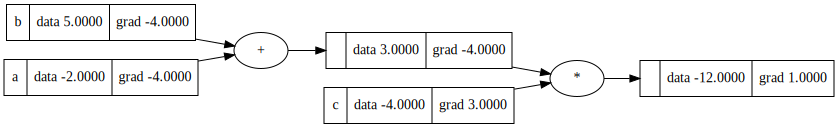

In [15]:
f.backward()
draw_dot(f)

In [16]:
# Input values
x1 = Tensor(2.0, label='x1')
x2 = Tensor(3.0, label='x2')

# Weights
w1 = Tensor(-3.0, label='w1')
w2 = Tensor(1.0, label='w2')

# bias
b = Tensor(6.0, label='b')

# y = tanh(Wx + b) = tanh(w1*x1 + w2*x2 + b)
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
y = x1w1x2w2 + b
y = y.tanh(); y.label = 'y'

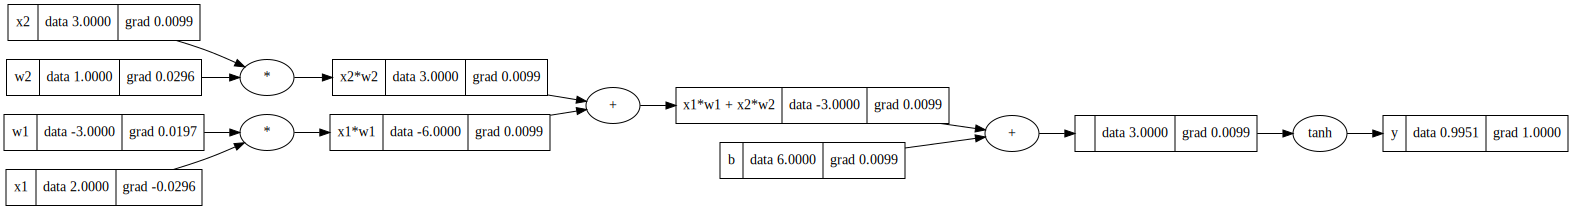

In [17]:
y.backward()
draw_dot(y)

### PyTorch Tensor

In [18]:
import torch
x1 = torch.tensor(2.0, requires_grad=False)
x2 = torch.tensor(3.0, requires_grad=False)
w1 = torch.tensor(-3.0, requires_grad=True)
w2 = torch.tensor(1.0, requires_grad=True)
b = torch.tensor(6.0, requires_grad=True)
y = torch.tanh(w1 * x1 + w2 * x2 + b)

# Visualize the computation graph
print(f"y: {y.data.item()}")
y.backward()
print(f"dy/dw1: {w1.grad.item()}")
print(f"dy/dw2: {w2.grad.item()}")

y: 0.9950547814369202
dy/dw1: 0.01973196305334568
dy/dw2: 0.029597945511341095


## Part 2: Linear Regression

In [19]:
# Linear network
class Linear:
    def __init__(self, input_size):
        # y = Wx + b
        self.weights = [Tensor(random.uniform(-1, 1)) for _ in range(input_size)]
        self.bias = Tensor(random.uniform(-1, 1))

    def __call__(self, x):
        """
        Forward pass
        y = Wx + b
        """
        x = sum((wi * xi for wi, xi in zip(self.weights, x)), self.bias)
        x = x.tanh()
        return x

    def parameters(self):
        return self.weights + [self.bias]

In [28]:
# Input values
x = [Tensor(-2.0), Tensor(5.0), Tensor(-4.0), Tensor(1.0)]

# Target value
y = Tensor(1.0)

# Initialize the linear network
linear = Linear(input_size=4)

print(f"Output: {linear(x).data}")
print(linear.parameters())

Output: 0.823593231126568
[data=(0.6451386341255214), data=(0.11317279872002572), data=(-0.3445662011198716), data=(-0.016247519286822776), data=(0.5302818001474361)]


In [29]:
# Learning rate
lr = 0.001

# Training loop
for step in range(10):
    # Forward pass
    output = linear(x)

    # Loss
    loss = (linear(x) - y) ** 2  # MSE loss

    # Backward pass
    for param in linear.parameters():
        param.gradient = 0
    loss.backward()

    # Update weights
    for param in linear.parameters():
        param.data = param.data - lr * param.gradient

    print(f"Step {step+1}, Loss: {loss.data}")

Step 1, Loss: 0.031119348104364453
Step 2, Loss: 0.030519476068382793
Step 3, Loss: 0.0299413360381907
Step 4, Loss: 0.029383793892305474
Step 5, Loss: 0.028845791943033237
Step 6, Loss: 0.028326342671758237
Step 7, Loss: 0.027824523065387626
Step 8, Loss: 0.027339469488165687
Step 9, Loss: 0.026870373031124155
Step 10, Loss: 0.02641647528840354
